In [142]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from scipy.stats import norm
from datetime import datetime, timedelta
import time
import urllib.request, json


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
token = 'd-bqq4Fx4pjuztAPQkYS'

In [10]:
datetime(2020,4,10)

datetime.datetime(2020, 4, 10, 0, 0)

In [11]:
start_time = (datetime(2020, 4, 18).strftime('%Y-%m-%d'))
start_time

'2020-04-18'

In [76]:
start_time = (datetime(2021, 4, 19).strftime('%Y-%m-%d'))
time_now = (datetime(2021, 4, 25).strftime('%Y-%m-%d'))
url=f'http://remobsapi.herokuapp.com/api/v1/waves?buoy=2&start_date={start_time}&end_date={time_now}&token={token}'
response = requests.get(url).json()
df = pd.DataFrame(response)

In [77]:
df.date_time = df.date_time.str[0:13]
df['buoy_id'] = pd.to_numeric(df['buoy_id'])
df['data_id'] = pd.to_numeric(df['data_id'])
df['period'] = pd.to_numeric(df['period'])
df['energy'] = pd.to_numeric(df['energy'])
df['wvdir'] = pd.to_numeric(df['wvdir'])
df['spread'] = pd.to_numeric(df['spread'])
df['mean_average_direction'] = pd.to_numeric(df['mean_average_direction'])
df['spread_direction'] = pd.to_numeric(df['spread_direction'])
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%dT%H')
df.sort_values('date_time', inplace=True)
total_df = df

In [78]:
total_df['values'] = pd.cut(total_df['period'], [2, 4, 7.5, 12, 18.4])

In [79]:
total_df['wvdir'] = total_df['wvdir'].astype(float)

In [80]:
total_df = total_df.groupby(['date_time', 'values']).agg({'energy': 'sum', 'wvdir': 'mean'}).reset_index()

In [81]:
total_df = total_df.dropna()

In [82]:
total_df['wvdir'] = np.round(total_df['wvdir']).astype('int')
total_df = total_df[total_df.date_time.dt.hour % 2 == 0]

In [83]:
date_time_norm = []
wvdir_norm = []
energy_norm = []
values_norm = []
for index, row in total_df.iterrows():
    wvd  = np.arange(row['wvdir'] - 4.75, row['wvdir'] + 4.75, 0.4)
    ener = norm.pdf(np.arange(-11,11 , 1),0,4.7) * row['energy'] * 80
    ener = np.insert(ener,[0],[0])
    ener = np.append(ener, [0])
    for i in range(len(ener)):
        date_time_norm.append(row['date_time'])
        values_norm.append(row['values'])
        wvdir_norm.append(wvd[i])
        energy_norm.append(ener[i])        

In [84]:
final_df = pd.DataFrame(np.array([date_time_norm, values_norm, wvdir_norm, energy_norm]).T, \
                        columns=['date_time', 'period', 'wvdir', 'energy'])

In [85]:
final_df['energy'] = final_df['energy'].astype(float) * 100
final_df['wvdir'] = final_df['wvdir'].astype(float)

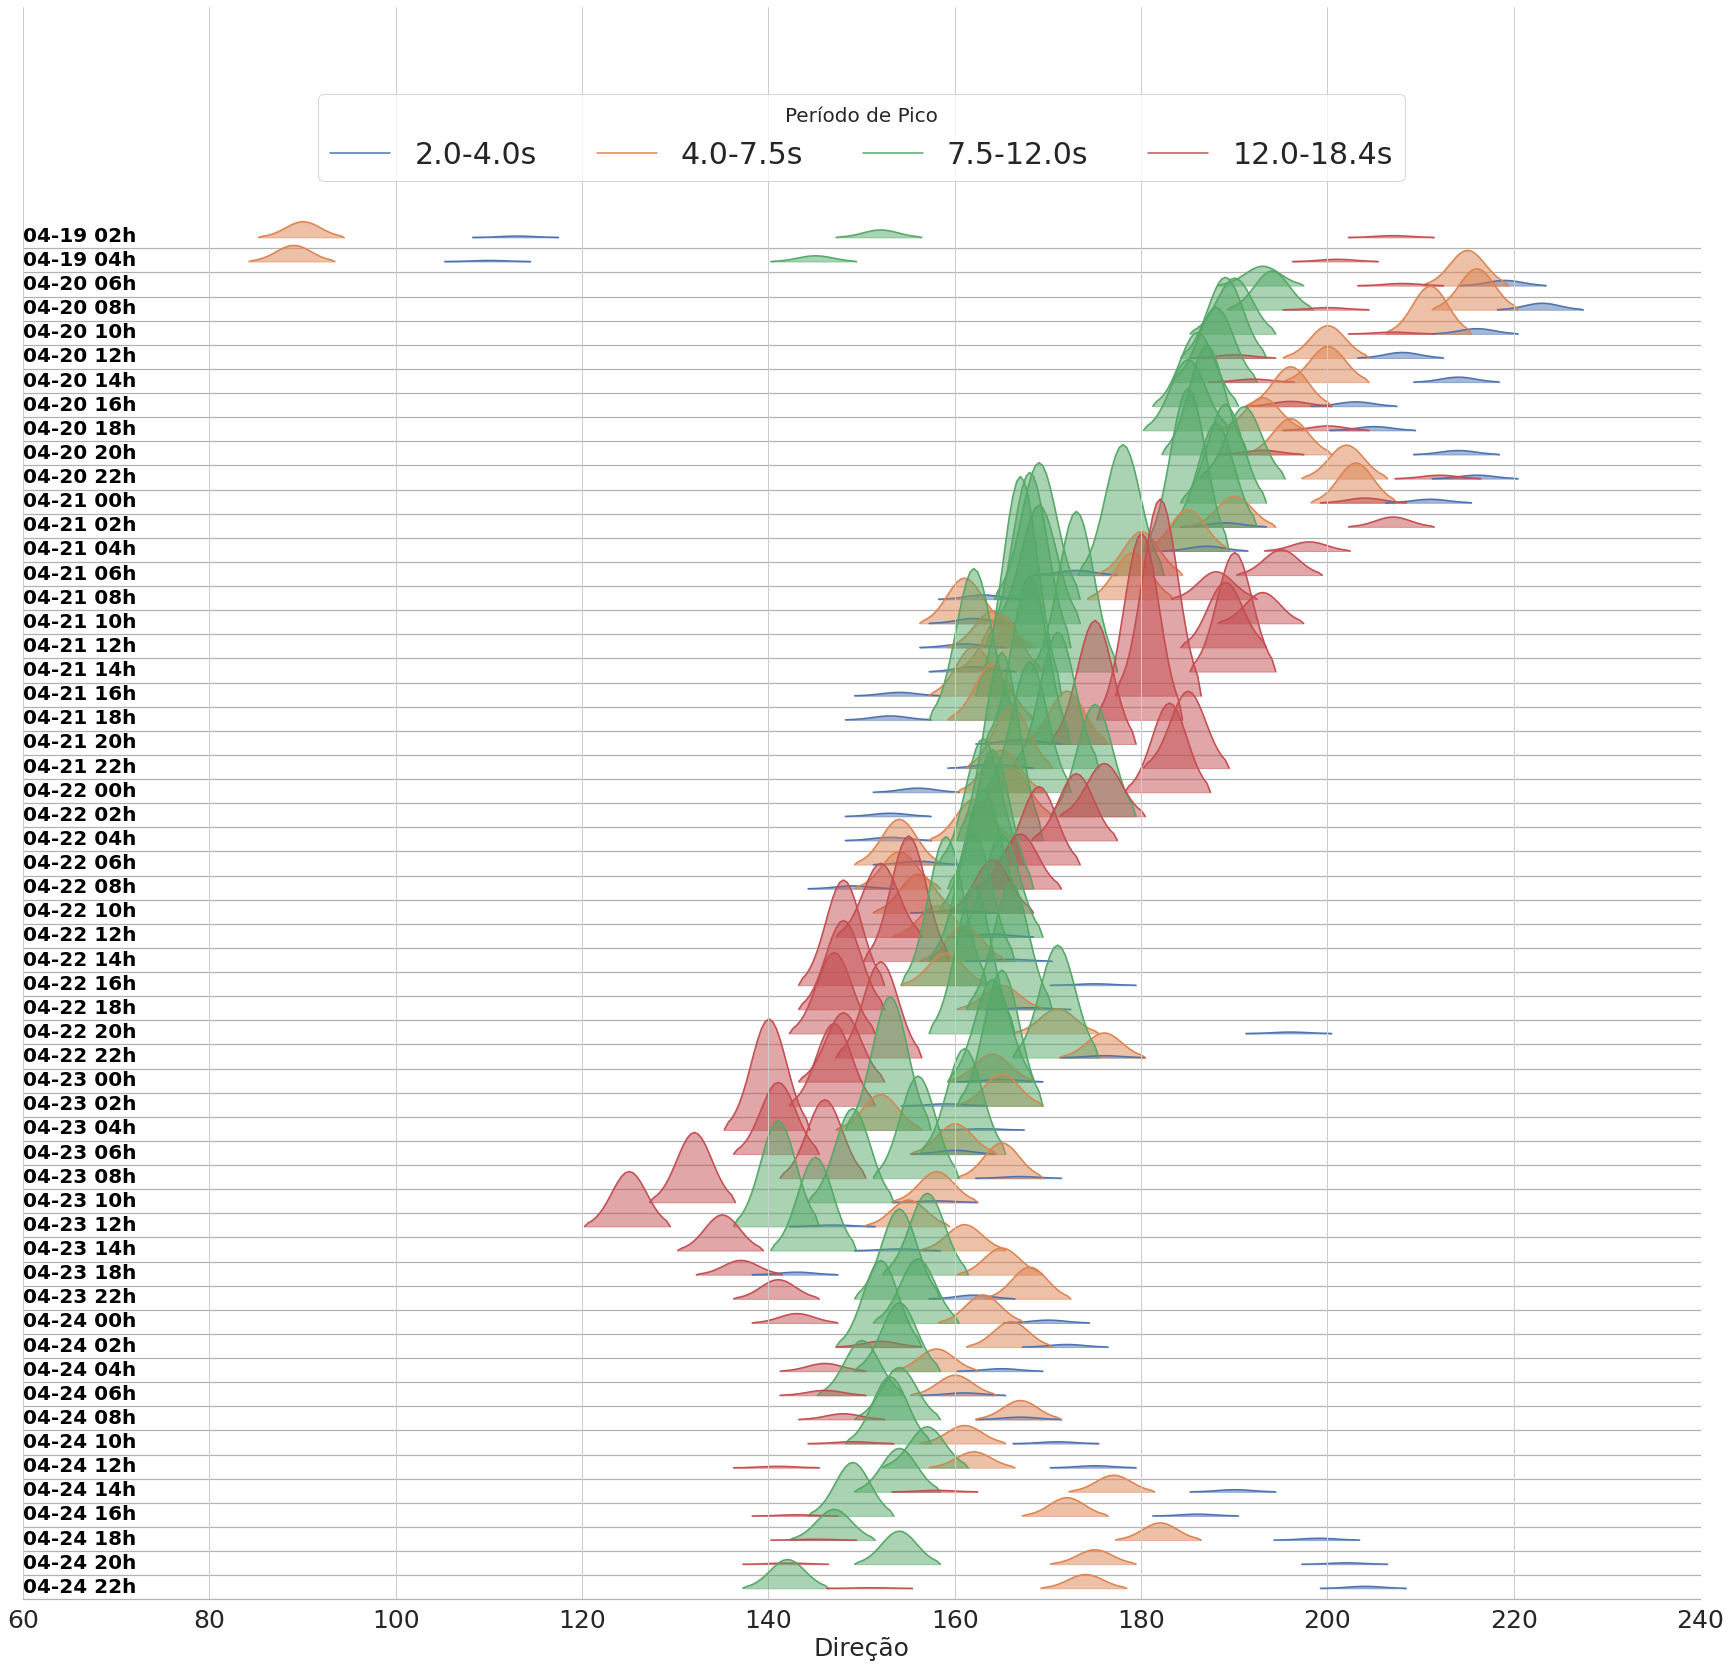

In [91]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

sns.color_palette("cubehelix", as_cmap=True)

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(final_df, row='date_time', hue='period', aspect=60, height=0.4)
# g.map(sns.kdeplot, "value", "name",
#       bw_adjust=5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
g.map(sns.lineplot, 'wvdir', 'energy')
# g.map(sns.kdeplot, "value", "name", clip_on=False, color="w", lw=2, bw_adjust=.5)
#g.map(plt.axhline, y=0, lw=1, clip_on=False, color=None)

# Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)

for ax in g.axes:
    for i in ax[0].lines:
        x1 = i.get_xydata()[:,0]
        y2 = i.get_xydata()[:,1]
        color = i.get_color()
        y1 = y2*0
        ax[0].fill_between(x1, y1=y1, y2=y2, color=color, alpha=0.5)
    ax[0].grid()
    ax[0].spines['right'].set_color('none')
    ax[0].spines['left'].set_color('none')
    ax[0].spines['bottom'].set_color('black')
    ax[0].spines['bottom'].set_alpha(0.3)
    ax[0].set_ylabel('')
    data = ax[0].title.get_text()[17:-16].replace('T', ' ') + "h"
    ax[0].text(0, 0.05, data, fontweight="bold", color=sns.xkcd_rgb['black'],
            ha="left", va="center", transform=ax[0].transAxes, fontsize=20)
    
# g.map(label, label="date_time")
g.set_titles("")
g.set_xlabels("Direção", fontsize=25)

# ticks = ['30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330', '360']
g.set_xticklabels(fontsize=25)
g.set (yticks=[])
# g.set(ylim=(10, max(total_df['name'])), xlim=(min(total_df['value']), max(total_df['value']) - 1))
# g.set(xlim=(0, 359))

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.9)
# plt.legend(loc="lower left", ncol=5)
label = ['2.0-4.0s', '4.0-7.5s', '7.5-12.0s', '12.0-18.4s']
plt.legend(bbox_to_anchor=(0.5, 6.3), loc=9, ncol=5, facecolor='white', \
           fontsize=30, markerscale=20, labels=label, title='Período de Pico', \
          title_fontsize=20)
# Remove axes details that don't play well with overlap
g.savefig('pleds.png')
# plt.savefig("pleds.png")

In [167]:
url=f'http://remobsapi.herokuapp.com/api/v1/data_buoys?buoy=2&start_date=2021-04-19&end_date=2021-04-25&token={token}'

response = requests.get(url).json()
df = pd.DataFrame(response)
for i in df.columns:
    try:
        df[i] = pd.to_numeric(df[i])
    except:
        pass
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%dT%H:%M:%S.000Z')
df.sort_values('date_time', inplace=True)

In [165]:
columns = ['swvht1', 'swvht2', 'wvdir1', 'wvdir2', 'wspd', 'gust', 'mxwvht1']
for i in columns:
    df.loc[(df[f"flag_{i}"] < 50) & (df[f"flag_{i}"] > 0), i] = np.nan

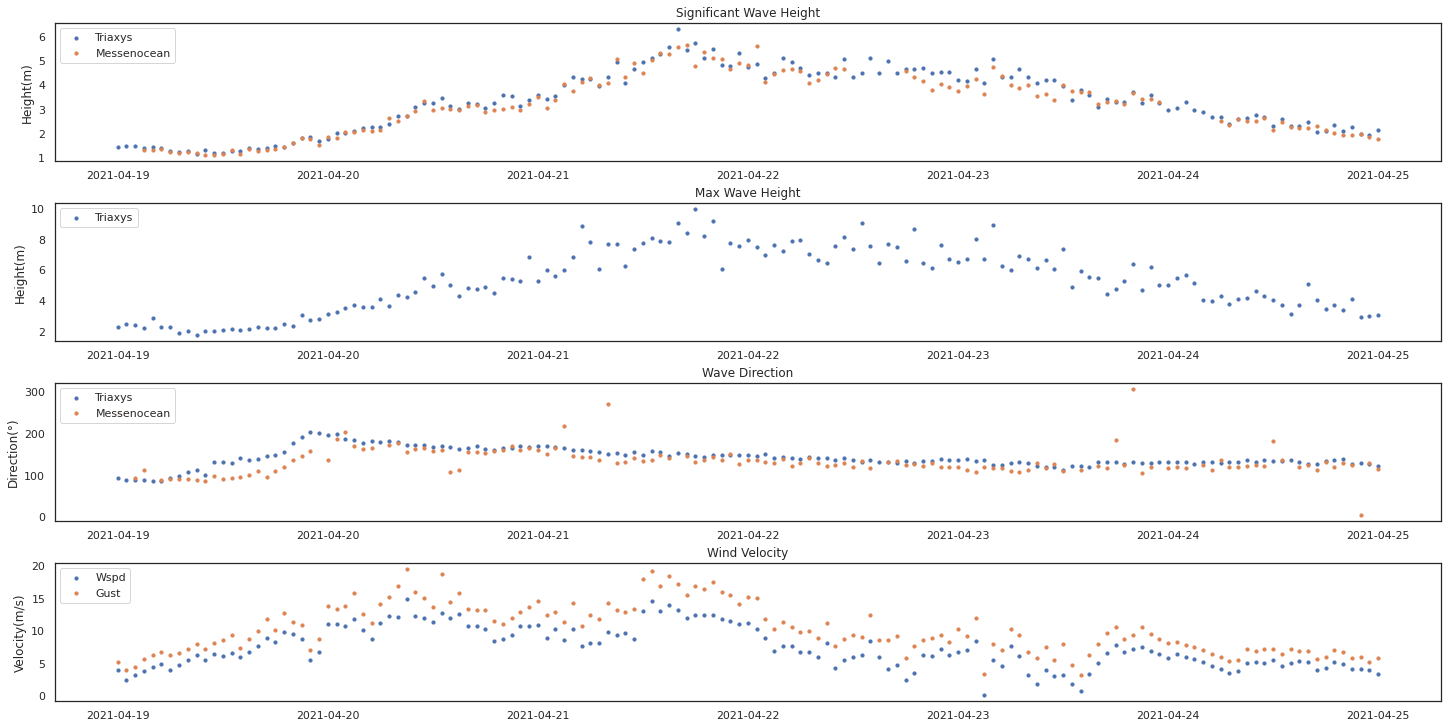

In [114]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig3.add_gridspec(4, 1)
ax1 = fig3.add_subplot(gs[0, 0])
ax1.scatter(df['date_time'],df['swvht1'], s=10)
ax1.scatter(df['date_time'],df['swvht2'], s=10)
ax1.set_title('Significant Wave Height')
ax1.legend(labels=['Triaxys', 'Messenocean'], loc=2, facecolor='white')
ax1.set_ylabel('Height(m)')
ax2 = fig3.add_subplot(gs[1, 0])
ax2.scatter(df['date_time'],df['mxwvht1'], s=10)
ax2.set_title('Max Wave Height')
ax2.set_ylabel('Height(m)')
ax2.legend(labels=['Triaxys'], loc=2, facecolor='white')
ax3 = fig3.add_subplot(gs[2, 0])
ax3.scatter(df['date_time'],df['wvdir1'], s=10)
ax3.scatter(df['date_time'],df['wvdir2'], s=10)
ax3.set_title('Wave Direction')
ax3.set_ylabel('Direction(°)')
ax3.legend(labels=['Triaxys', 'Messenocean'], loc=2, facecolor='white')
ax4 = fig3.add_subplot(gs[3, 0])
ax4.scatter(df['date_time'],df['wspd'], s=10)
ax4.scatter(df['date_time'],df['gust'], s=10)
ax4.set_title('Wind Velocity')
ax4.set_ylabel('Velocity(m/s)')
ax4.legend(labels=['Wspd', 'Gust'], loc=2, facecolor='white')

plt.savefig("wave_wind.png")

In [163]:
url=f'http://remobsapi.herokuapp.com/api/v1/models?buoy=2&start_date=2021-04-19&end_date=2021-04-25&token={token}'
response = requests.get(url).json()
df_model = pd.DataFrame(response)
for i in df_model.columns:
    try:
        df_model[i] = pd.to_numeric(df_model[i])
    except:
        pass
df_model['date_time'] = pd.to_datetime(df_model['date_time'], format='%Y-%m-%dT%H:%M:%S.000Z')
df_model.sort_values('date_time', inplace=True)

In [116]:
df_model.columns
df_gfs = df_model[df_model['model'] == 'GFS']
df_icon = df_model[df_model['model'] == 'ICON']
df_cosmo = df_model[df_model['model'] == 'COSMO']

In [117]:
df_model.columns

Index(['buoy_id', 'model', 'date_time', 'lat', 'lon', 'swvht', 'wvdir', 'tp',
       'wspd', 'wdir'],
      dtype='object')

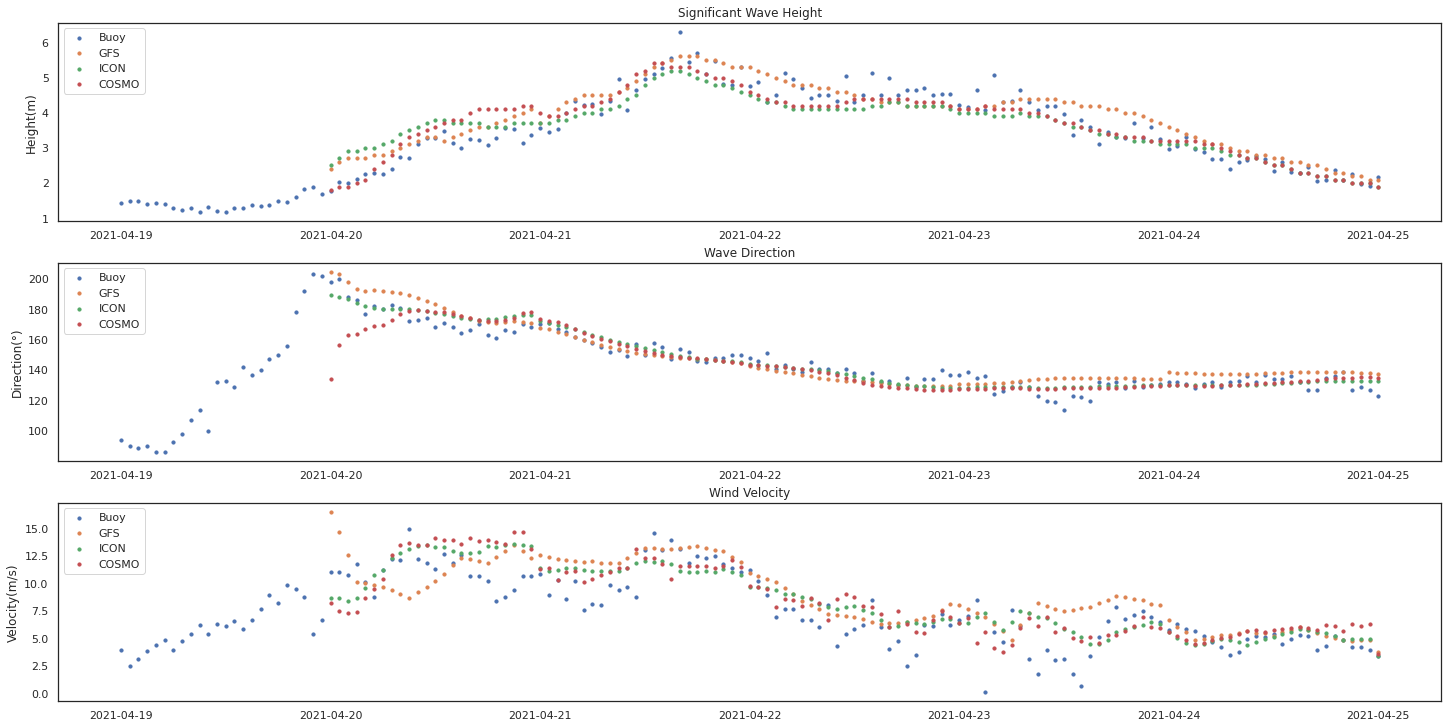

In [118]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(df['date_time'],df['swvht1'], s=10)
ax1.scatter(df_gfs['date_time'],df_gfs['swvht'], s=10)
ax1.scatter(df_icon['date_time'],df_icon['swvht'], s=10)
ax1.scatter(df_cosmo['date_time'],df_cosmo['swvht'], s=10)
ax1.set_title('Significant Wave Height')
ax1.legend(labels=['Buoy', 'GFS', 'ICON', 'COSMO'], loc=2, facecolor='white')
ax1.set_ylabel('Height(m)')
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(df['date_time'],df['wvdir1'], s=10)
ax3.scatter(df_gfs['date_time'],df_gfs['wvdir'], s=10)
ax3.scatter(df_icon['date_time'],df_icon['wvdir'], s=10)
ax3.scatter(df_cosmo['date_time'],df_cosmo['wvdir'], s=10)
ax3.set_title('Wave Direction')
ax3.set_ylabel('Direction(°)')
ax3.legend(labels=['Buoy', 'GFS', 'ICON', 'COSMO'], loc=2, facecolor='white')
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(df['date_time'],df['wspd'], s=10)
ax4.scatter(df_gfs['date_time'],df_gfs['wspd'] * 0.514444, s=10)
ax4.scatter(df_icon['date_time'],df_icon['wspd'] * 0.514444, s=10)
ax4.scatter(df_cosmo['date_time'],df_cosmo['wspd'] * 0.514444, s=10)
ax4.set_title('Wind Velocity')
ax4.set_ylabel('Velocity(m/s)')
ax4.legend(labels=['Buoy', 'GFS', 'ICON', 'COSMO'], loc=2, facecolor='white')
plt.savefig("wave_wind_model.png")

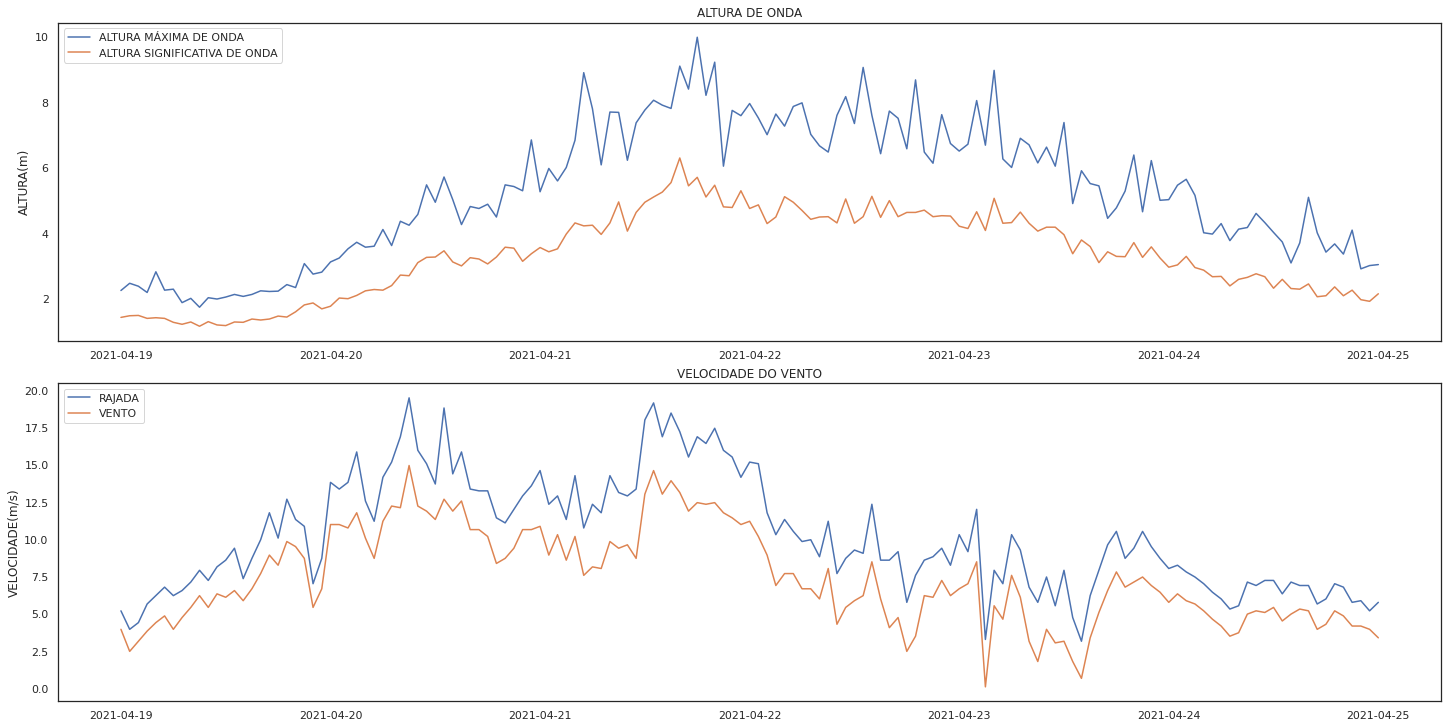

In [119]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig3.add_gridspec(2, 1)
ax1 = fig3.add_subplot(gs[0, 0])
ax1.plot(df['date_time'],df['mxwvht1'])
ax1.plot(df['date_time'],df['swvht1'])
ax1.set_title('ALTURA DE ONDA')
ax1.legend(labels=['ALTURA MÁXIMA DE ONDA', 'ALTURA SIGNIFICATIVA DE ONDA'], loc=2, facecolor='white')
ax1.set_ylabel('ALTURA(m)')
ax4 = fig3.add_subplot(gs[1, 0])
ax4.plot(df['date_time'],df['gust'])
ax4.plot(df['date_time'],df['wspd'])
ax4.set_title('VELOCIDADE DO VENTO')
ax4.set_ylabel('VELOCIDADE(m/s)')
ax4.legend(labels=['RAJADA', 'VENTO'], loc=2, facecolor='white')
plt.savefig("wave_wind_plot.png")

In [143]:
def remove_dup_columns(result):
    keep_names = set()
    keep_icols = list()
    for icol, name in enumerate(result.columns):
        if name not in keep_names:
            keep_names.add(name)
            keep_icols.append(icol)
    return result.iloc[:, keep_icols]


In [144]:
time1 = time.mktime(time.strptime("2021-04-19", "%Y-%m-%d"))
time2 = time.mktime(time.strptime("2021-04-25", "%Y-%m-%d"))

url_address = f"http://simcosta.furg.br/api/metereo_data?boiaID=3&type=json&time1={time1}&time2={time2}&params=Average_wind_direction_N,Last_sampling_interval_gust_speed,Average_Dew_Point,Average_Pressure,Solar_Radiation_Average_Reading,Average_Air_Temperature,Instantaneous_Humidity,Average_Humidity,Average_wind_speed"
with urllib.request.urlopen(url_address) as url:
    data = json.loads(url.read().decode())
    data = pd.DataFrame(data)
url_address = f"http://simcosta.furg.br/api/oceanic_data?boiaID=3&type=json&time1={time1}&time2={time2}&params=H10,HAvg,Hsig_Significant_Wave_Height_m,HM0,Mean_Wave_Direction_deg,Hmax_Maximum_Wave_Height_m,ZCN,Tp5,TAvg,T10,Tsig,Mean_Spread_deg,TP_Peak_Period_seconds,Average_Salinity,Average_Temperature_deg_C,Average_Temperature_C,Average_CDOM_QSDE,Average_Chlorophyll_Fluorescence,Average_Dissolved_Oxygen,Average_Nephelometric_Turbidity_Unit_NTU,Cell_Average_Direction_N,Cell_Average_Magnitude_mm_s"
with urllib.request.urlopen(url_address) as url:
    data1 = json.loads(url.read().decode())
    data1 = pd.DataFrame(data1)

result = pd.concat([data,  data1], axis=1, join='inner')

result = remove_dup_columns(result)

result['date_time'] = pd.to_datetime(result.iloc[:,0:6])
columns = ['YEAR','MONTH','DAY','HOUR','MINUTE','SECOND','Hmt',
    'Avg_Wnd_Dir','M_Decl','Avg_W_Tmp1','Avg_Sal','Avg_Spre_N',
    'Avg_Wv_Dir','Avg_Cel1_Mag','Avg_Cel1_Dir','Avg_Cel1_Dir_N',
    'Avg_Turb','Avg_Chl','Avg_DO','ZCN','HM0','TAvg','Tp5',
    'T10','HAvg','Tsig','CDOM','H10','Avg_Sol_Rad']

result.drop(columns=columns, inplace=True)

result.columns = ['pres', 'atmp', 'rh', 'dewpt', 'wspd', 'wdir', 'gust', 'swvht', 'mxwvht', 'tp', 'sst', 'wvspread', 'wvdir', 'date_time']

result = result.replace(to_replace =['None', 'NULL', ' ', ''],
                        value =np.nan)

result.head()

,pres,atmp,rh,dewpt,wspd,wdir,gust,swvht,mxwvht,tp,sst,wvspread,wvdir,date_time
0,1013.95,None,None,None,5.70,222.10,7.20,0.85,1.27,6.70,21.40,35.00,140.10,2021-04-19 03:21:00
1,1013.69,None,None,None,3.10,229.10,3.50,0.87,1.35,7.40,21.69,38.00,146.10,2021-04-19 04:21:00
2,1013.46,None,None,None,2.70,218.10,3.10,0.87,1.39,6.90,21.63,36.00,140.10,2021-04-19 04:51:00
3,1013.08,None,None,None,1.90,244.10,2.50,0.87,1.32,6.70,21.72,37.00,138.10,2021-04-19 05:51:00
4,1012.87,None,None,None,1.40,32.10,2.10,0.87,1.49,16.70,21.70,35.00,142.10,2021-04-19 06:21:00


In [152]:
for column in result.drop(columns='date_time').columns:
    result[column] = pd.to_numeric(result[column])

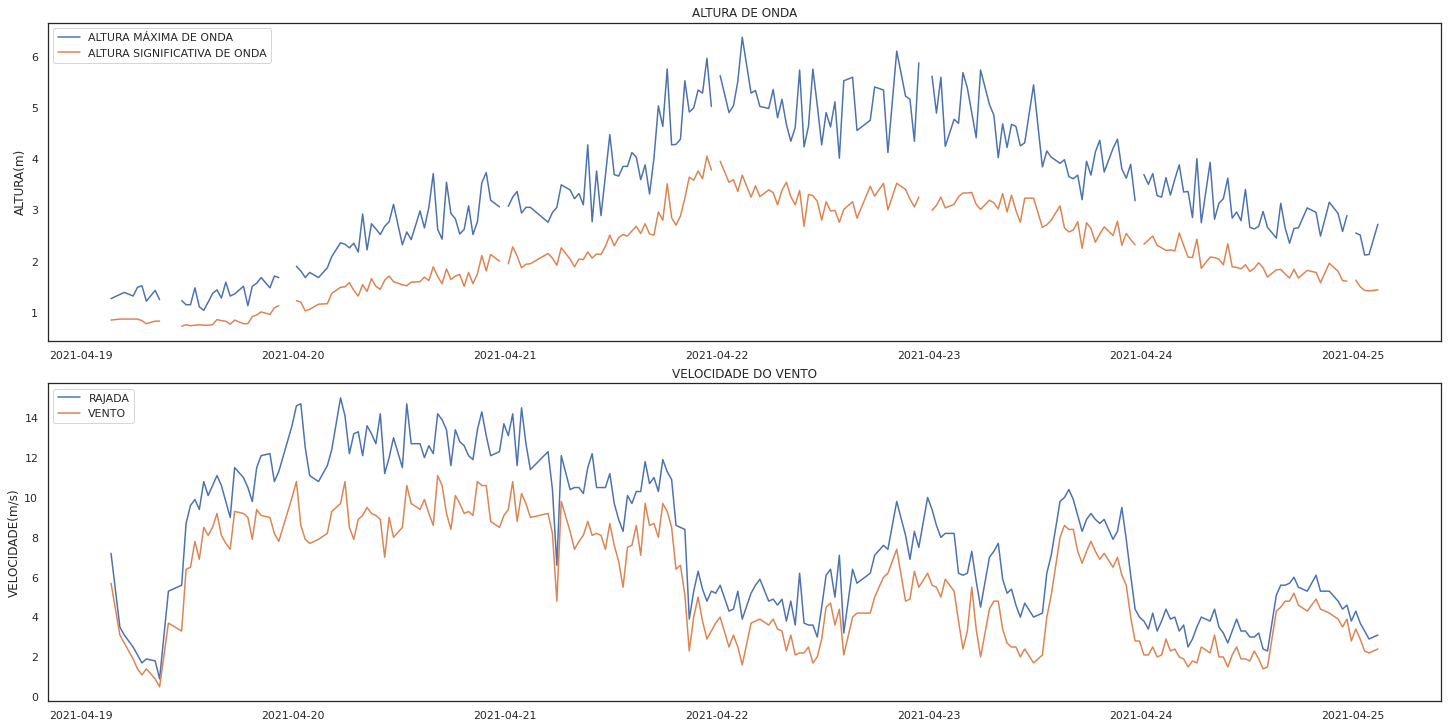

In [154]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig3.add_gridspec(2, 1)
ax1 = fig3.add_subplot(gs[0, 0])
ax1.plot(result['date_time'],result['mxwvht'])
ax1.plot(result['date_time'],result['swvht'])
ax1.set_title('ALTURA DE ONDA')
ax1.legend(labels=['ALTURA MÁXIMA DE ONDA', 'ALTURA SIGNIFICATIVA DE ONDA'], loc=2, facecolor='white')
ax1.set_ylabel('ALTURA(m)')
ax4 = fig3.add_subplot(gs[1, 0])
ax4.plot(result['date_time'],result['gust'])
ax4.plot(result['date_time'],result['wspd'])
ax4.set_title('VELOCIDADE DO VENTO')
ax4.set_ylabel('VELOCIDADE(m/s)')
ax4.legend(labels=['RAJADA', 'VENTO'], loc=2, facecolor='white')
plt.savefig("wave_wind_plot_simcosta.png")

In [169]:
url=f'http://remobsapi.herokuapp.com/api/v1/data_buoys?buoy=19&start_date=2021-04-19&end_date=2021-04-25&token={token}'

response = requests.get(url).json()
df_t = pd.DataFrame(response)
for i in df_t.columns:
    try:
        df_t[i] = pd.to_numeric(df_t[i])
    except:
        pass
df_t['date_time'] = pd.to_datetime(df_t['date_time'], format='%Y-%m-%dT%H:%M:%S.000Z')
df_t.sort_values('date_time', inplace=True)

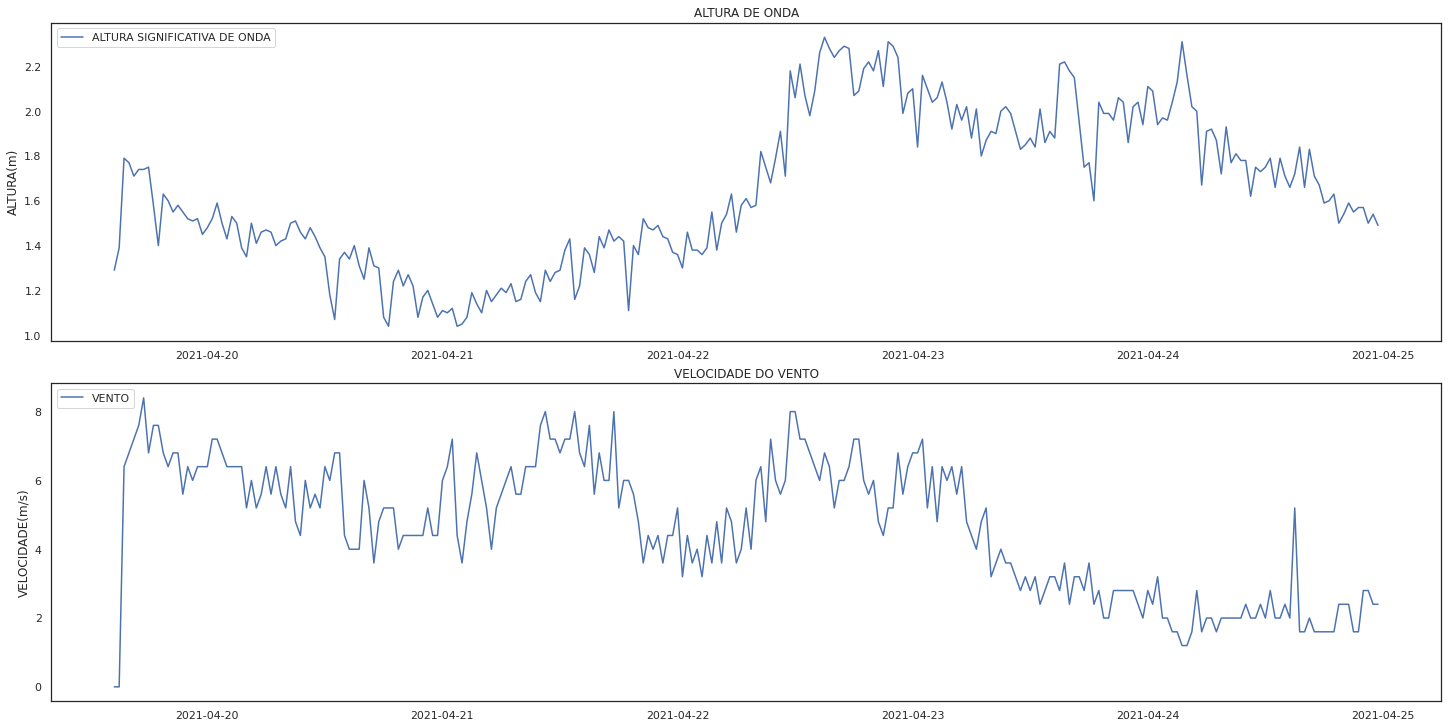

In [159]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig3.add_gridspec(2, 1)
ax1 = fig3.add_subplot(gs[0, 0])
ax1.plot(df_t['date_time'],df_t['swvht1'])
ax1.set_title('ALTURA DE ONDA')
ax1.legend(labels=['ALTURA SIGNIFICATIVA DE ONDA'], loc=2, facecolor='white')
ax1.set_ylabel('ALTURA(m)')
ax4 = fig3.add_subplot(gs[1, 0])
ax4.plot(df_t['date_time'],df_t['wspd'])
ax4.set_title('VELOCIDADE DO VENTO')
ax4.set_ylabel('VELOCIDADE(m/s)')
ax4.legend(labels=['VENTO'], loc=2, facecolor='white')
plt.savefig("wave_wind_plot_trindade.png")

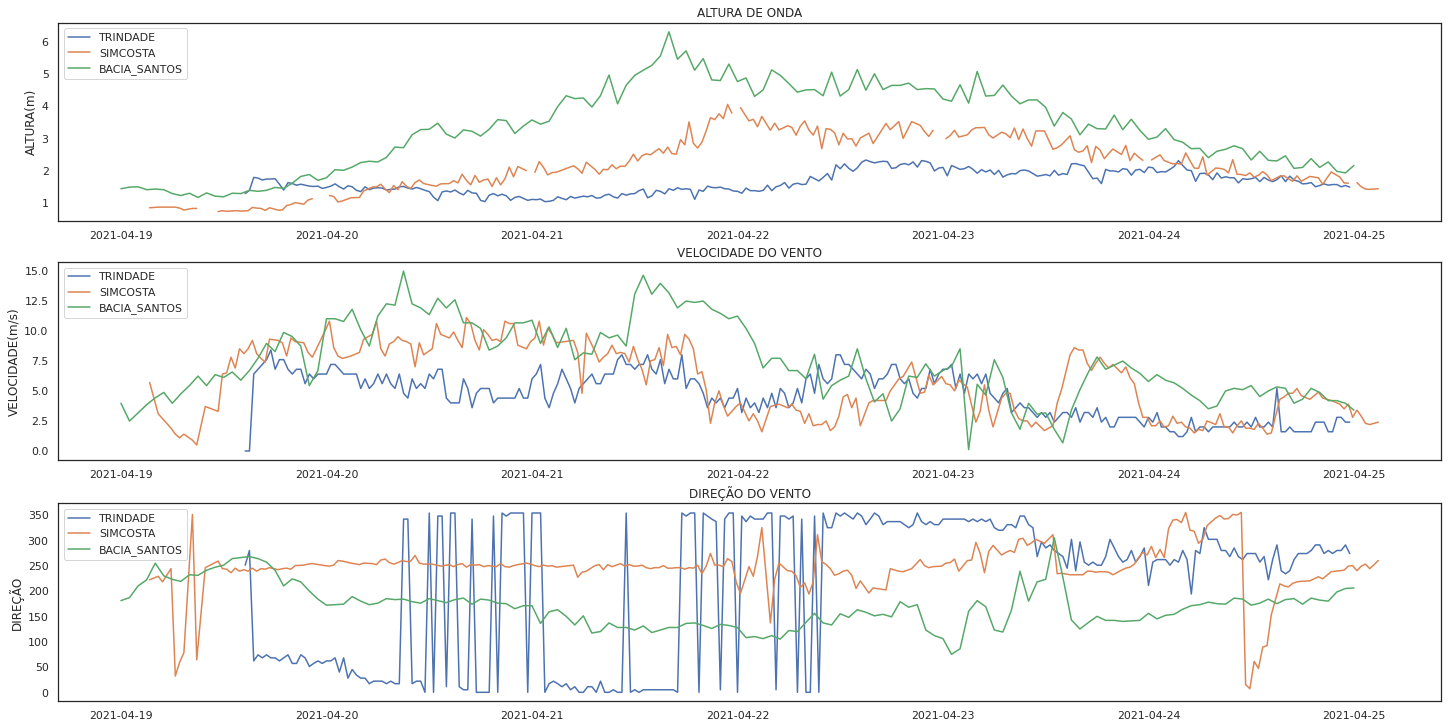

In [174]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,10))
gs = fig3.add_gridspec(3, 1)
ax1 = fig3.add_subplot(gs[0, 0])
ax1.plot(df_t['date_time'],df_t['swvht1'])
ax1.plot(result['date_time'],result['swvht'])
ax1.plot(df['date_time'],df['swvht1'])
ax1.set_title('ALTURA DE ONDA')
ax1.legend(labels=['TRINDADE','SIMCOSTA', 'BACIA_SANTOS'], loc=2, facecolor='white')
ax1.set_ylabel('ALTURA(m)')
ax4 = fig3.add_subplot(gs[1, 0])
ax4.plot(df_t['date_time'],df_t['wspd'])
ax4.plot(result['date_time'],result['wspd'])
ax4.plot(df['date_time'],df['wspd'])
ax4.set_title('VELOCIDADE DO VENTO')
ax4.set_ylabel('VELOCIDADE(m/s)')
ax4.legend(labels=['TRINDADE','SIMCOSTA', 'BACIA_SANTOS'], loc=2, facecolor='white')
ax5 = fig3.add_subplot(gs[2, 0])
ax5.plot(df_t['date_time'],df_t['wdir'])
ax5.plot(result['date_time'],result['wdir'])
ax5.plot(df['date_time'],df['wdir'])
ax5.set_title('DIREÇÃO DO VENTO')
ax5.set_ylabel('DIREÇÃO')
ax5.legend(labels=['TRINDADE','SIMCOSTA', 'BACIA_SANTOS'], loc=2, facecolor='white')
plt.savefig("wave_wind_plot_comparison.png")